In [147]:
from keras import *
import keras
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
import tensorflow.keras
from tensorflow import linalg

import torch

import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# Preprocessing

Разложим все изображения на факторы с помощью `Canonical Polyadic Decomposition` и с помощью `Tucker Decomposition`.

1. Для `CPD` сохраним факторы для обучения сети
2. Для `CPD` и `TD` восстановим из факторов исходные тензор-изображения. Ниже мы обучим на них сетку, чтобы понять, насколько упадёт точность после восстановления.

In [137]:
# ~utils

def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    c = c.reshape(-1, 1)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]

loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root="./CIFAR-10/", train=True, download=False),
    batch_size=1, shuffle=False, num_workers=2)

In [ ]:
recovered_after_CPD = []
recovered_after_TD  = []

fA, fB, fC = [], [], [] # списки для сохранения CPD факторов

for ind,img in enumerate(loader.dataset.data):
    img = torch.tensor(img) * 1.
 
    # Раскладываем и восстанавливаем по Такеру
    tt = tl.decomposition.tucker(img, rank=(5, 5, 3))
    restored_tucker_tensor = tl.tucker_to_tensor(tt)
    recovered_after_TD.append(tt)
    
    # Раскладываем и восстанавливаем канонически:
    a, b, c = parafac(tensor=img, rank=3, n_iter_max=90).factors
    
    fA.append(a.numpy())
    fB.append(b.numpy())
    fC.append(c.numpy())
 
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])    

    restored_tensor = torch.tensor(R1s.sum(axis=3)).numpy()
    
    recovered_after_CPD.append(restored_tensor)
    
    if ind % 1000 == 0:
        print(f"Осталось {50000-ind} объектов")

___
___

# Factor model

Построем модель для обучения на факторах `fA`, `fB` и `fC` (полученных после `CPD`):

In [139]:
def build_cifar_model_based_on_CPD_factors():
    
    # -- -- -- -- MODEL A -- -- -- 
    
    inputs_A = Input(shape=(32, 3,))
    x1 = Reshape((32, 3, 1))(inputs_A)
    x1 = Dropout(0.15)(x1)
    x1 = BatchNormalization()(x1)
    
    x1 = Conv2D(32, kernel_size=(5, 5), padding="same")(x1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)
    x1 = Activation("tanh")(x1)
    
    x1 = Conv2D(32, kernel_size=(5, 1), padding="same")(x1)
    x1 = MaxPool2D(pool_size=(2, 1))(x1)
    x1 = LeakyReLU()(x1)
    
    x1 = Conv2D(16, kernel_size=(3, 1), padding="same")(x1)

    x1 = Flatten()(x1)
    x1 = Dense(50)(x1)
    x1 = Dense(20)(x1)
    x1 = LeakyReLU()(x1)
    x1 = Dropout(0.2)(x1)
    
    model1 = Model(inputs=inputs_A, outputs=x1)
    
    # -- -- -- -- MODEL B -- -- --     
    
    inputsB = Input(shape=(32, 3,))
    x2 = Reshape((32, 3, 1))(inputsB)
    x2 = Dropout(0.15)(x2)
    x2 = BatchNormalization()(x2)

    x2 = Conv2D(32, kernel_size=(5, 5), padding="same")(x2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Activation("tanh")(x2)
    
    x2 = Conv2D(32, kernel_size=(5, 1), padding="same")(x2)
    x2 = MaxPool2D(pool_size=(2, 1))(x2)
    x2 = LeakyReLU()(x2)
    
    x2 = Conv2D(16, kernel_size=(3, 1), padding="same")(x2)
    
    x2 = Flatten()(x2)
    x2 = Dense(50)(x2)
    x2 = Dense(20)(x2)
    x2 = LeakyReLU()(x2)
    x2 = Dropout(0.2)(x2)
    
    model2 = Model(inputs=inputsB, outputs=x2)
    
    # -- -- -- -- MODEL C -- -- -- 
    
    inputs_C = Input(shape=(3, 3,))
    x3 = Reshape((3, 3, 1))(inputs_C)
    
    x3 = Conv2D(12, kernel_size=(2, 2), padding='same')(x3)
    x3 = Activation("tanh")(x3)
    
    x3 = Flatten()(x3)
    x3 = Dense(20)(x3)
    x3 = Dense(20)(x3)
    x3 = Activation("tanh")(x3)
    x3 = Dropout(0.1)(x3)

    model3 = Model(inputs=inputs_C, outputs=x3)
    
    # -- -- -- -- MERGE THE MODELS -- -- -- 
    
    merged_outputs = Add()([model1.output,model2.output,model3.output])
    
    river_100 = Dense(100)(merged_outputs)
    actived = LeakyReLU()(river_100)
    droped = Dropout(0.2)(actived)

    river_50 = Dense(50)(droped)
    actived = LeakyReLU()(river_100)
    
    river_20 = Dense(20)(actived)
    residualed = Add()([merged_outputs, river_20])
    actived = LeakyReLU()(residualed)
    
    outputs = Dense(10, activation="softmax")(actived)
    
    model = Model(inputs=[model1.input, model2.input, model3.input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

___
___

# General model

Построем модель аналогичную по структуре модели сверху для обучения на обычном датасете `CIFAR-10`, а также на восстановленных тензорах:

In [189]:
Y = to_categorical(loader.dataset.targets, num_classes=10)

In [204]:
def build_cifar_model_based_on_solid_tensors():
    
    inputs = Input(shape=(32, 32, 3,))
    x = Reshape((32, 32, 3))(inputs)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(5, 5), padding="same")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Activation("tanh")(x)
    
    x = Conv2D(32, kernel_size=(5, 1), padding="same")(x)
    x = MaxPool2D(pool_size=(2, 1))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(16, kernel_size=(3, 1), padding="same")(x)

    x = Flatten()(x)
    x = Dense(50)(x)
    x = Dense(20)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    
    river_100 = Dense(100)(x)
    actived = LeakyReLU()(river_100)
    droped = Dropout(0.2)(actived)

    river_50 = Dense(50)(droped)
    actived = LeakyReLU()(river_100)
    
    river_20 = Dense(20)(actived)
    residualed = Add()([river_20, x])
    actived = LeakyReLU()(residualed)
    
    outputs = Dense(10, activation="softmax")(actived)
    
    model = Model(inputs=[inputs], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

___
___

# Fitting the models

In [207]:
# модель для факторного обучения
cpd_factors_model  = build_cifar_model_based_on_CPD_factors()
# модель для обучения на оригиналах
tensor_based_model = build_cifar_model_based_on_solid_tensors()
# модель для обучения на восстановленных после CPD
cpd_restored_based_model = build_cifar_model_based_on_solid_tensors()
# модель для обучения на восстановленных после TD
td_restored_based_model = build_cifar_model_based_on_solid_tensors()

In [224]:
with open(r"/Users/god/Documents/Paper/data/CIFAR_decomposed_and_restored_CPD.pkl", "rb") as f:
    cpd_restored = pickle.load(f)
    
with open(r"/Users/god/Documents/Paper/data/CIFAR_decomposed_and_restored_Tucker.pkl", 'rb') as f:
    td_restored = pickle.load(f)

In [226]:
n_epochs = 200

try:
    tensor_based_model.fit(
        [loader.dataset.data[:40000]], Y[:40000],
        batch_size=32, epochs=n_epochs,
        validation_data=([loader.dataset.data[40000:]], Y[40000:])
    )

    print("ATTENTION: MODEL FITTING WITH ORIGINAL DATA: SUCCESS")
except:
    print("ATTENTION: MODEL FITTING WITH ORIGINAL DATA: FAIL")
    
try:
    cpd_restored_based_model.fit(
        [cpd_restored[:40000]], Y[:40000],
        batch_size=32, epochs=n_epochs,
        validation_data=([cpd_restored[40000:]], Y[40000:])
    )

    print("ATTENTION: MODEL FITTING WITH CPD RESTORED DATA: SUCCESS")
except:
    print("ATTENTION: MODEL FITTING WITH CPD RESTORED DATA: FAIL")
    
try:
    td_restored_based_model.fit(
        [td_restored[:40000]], Y[:40000],
        batch_size=32, epochs=n_epochs,
        validation_data=([td_restored[40000:]], Y[40000:])
    )

    print("ATTENTION: MODEL FITTING WITH TD RESTORED DATA: SUCCESS")
except:
    print("ATTENTION: MODEL FITTING WITH TD RESTORED DATA: FAIL")

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 72s 2ms/step - loss: 1.7382 - accuracy: 0.3683 - val_loss: 1.5193 - val_accuracy: 0.4391
Epoch 2/200
40000/40000 [==============================] - 58s 1ms/step - loss: 1.4686 - accuracy: 0.4685 - val_loss: 1.3613 - val_accuracy: 0.5110
Epoch 3/200
40000/40000 [==============================] - 55s 1ms/step - loss: 1.3726 - accuracy: 0.5041 - val_loss: 1.3032 - val_accuracy: 0.5411
Epoch 4/200
40000/40000 [==============================] - 54s 1ms/step - loss: 1.3156 - accuracy: 0.5259 - val_loss: 1.3644 - val_accuracy: 0.5192
Epoch 5/200
40000/40000 [==============================] - 55s 1ms/step - loss: 1.2703 - accuracy: 0.5436 - val_loss: 1.2834 - val_accuracy: 0.5456
Epoch 6/200
40000/40000 [==============================] - 58s 1ms/step - loss: 1.2375 - accuracy: 0.5602 - val_loss: 1.3119 - val_accuracy: 0.5419
Epoch 7/200
40000/40000 [==============================] - 56s

In [263]:
td_restored_based_model.fit(
    [td_restored[:40000]], Y[:40000],
    batch_size=32, epochs=200,
    validation_data=([td_restored[40000:]], Y[40000:])
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
40000/40000 [==============================] - 85s 2ms/step - loss: 1.7444 - accuracy: 0.3645 - val_loss: 1.6731 - val_accuracy: 0.4049
Epoch 2/200
40000/40000 [==============================] - 66s 2ms/step - loss: 1.5255 - accuracy: 0.4460 - val_loss: 1.4681 - val_accuracy: 0.4707
Epoch 3/200
40000/40000 [==============================] - 70s 2ms/step - loss: 1.4476 - accuracy: 0.4753 - val_loss: 1.3985 - val_accuracy: 0.4985
Epoch 4/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.3982 - accuracy: 0.4958 - val_loss: 1.4077 - val_accuracy: 0.4989
Epoch 5/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.3588 - accuracy: 0.5112 - val_loss: 1.4141 - val_accuracy: 0.4968
Epoch 6/200
40000/40000 [==============================] - 58s 1ms/step - loss: 1.3286 - accuracy: 0.5221 - val_loss: 1.5500 - val_accuracy: 0.4450
Epoch 7/200
40000/40000 [==============================] - 58s

Сохраним модельки

In [265]:
with open("tensor_based_model.pkl", "wb") as output:
    pickle.dump(tensor_based_model, output)

with open("cpd_restored_based_model.pkl", "wb") as output:
    pickle.dump(cpd_restored_based_model, output)

with open("td_restored_based_model.pkl", "wb") as output:
    pickle.dump(td_restored_based_model, output)

# Анализ результатов

Построим графики accuracy и loss:

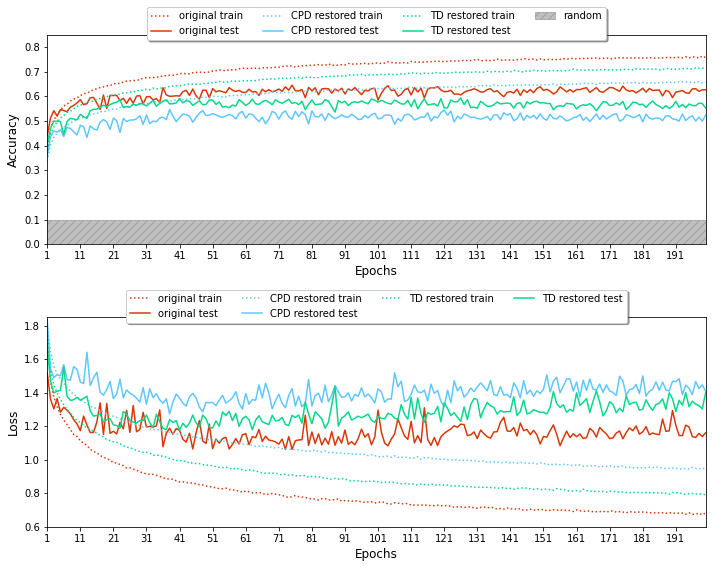

In [282]:
fig, axs = plt.subplots(2, figsize=(10, 8))
plt.setp(axs, ylim=[0, 0.6])

rect = matplotlib.patches.Rectangle((0,0), 200, 0.1, color="grey", alpha=0.5, hatch="///", label="random")
axs[0].add_patch(rect)

axs[0].plot(range(1, len(tensor_based_model.history.history['accuracy'])+1), tensor_based_model.history.history['accuracy'], c="#D83708", label="original train", linestyle=":")
axs[0].plot(range(1, len(tensor_based_model.history.history['val_accuracy'])+1), tensor_based_model.history.history['val_accuracy'], c="#D83708", label="original test")
axs[0].plot(range(1, len(cpd_restored_based_model.history.history['accuracy'])+1), cpd_restored_based_model.history.history['accuracy'], c="#5EC7FF", label="CPD restored train", linestyle=":")
axs[0].plot(range(1, len(cpd_restored_based_model.history.history['val_accuracy'])+1), cpd_restored_based_model.history.history['val_accuracy'], c="#5EC7FF", label="CPD restored test")
axs[0].plot(range(1, len(td_restored_based_model.history.history['accuracy'])+1), td_restored_based_model.history.history['accuracy'], c="#08D889", label="TD restored train", linestyle=":")
axs[0].plot(range(1, len(td_restored_based_model.history.history['val_accuracy'])+1), td_restored_based_model.history.history['val_accuracy'], c="#08D889", label="TD restored test")


axs[0].set_xticks([i for i in range(1, n_epochs, 10)])
axs[1].set_xticks([i for i in range(1, n_epochs, 10)])


axs[1].plot(range(1, len(tensor_based_model.history.history['loss'])+1), tensor_based_model.history.history['loss'], c="#D83708", label="original train", linestyle=":")
axs[1].plot(range(1, len(tensor_based_model.history.history['val_loss'])+1), tensor_based_model.history.history['val_loss'], c="#D83708", label="original test")
axs[1].plot(range(1, len(cpd_restored_based_model.history.history['loss'])+1), cpd_restored_based_model.history.history['loss'], c="#5EC7FF", label="CPD restored train", linestyle=":")
axs[1].plot(range(1, len(cpd_restored_based_model.history.history['val_loss'])+1), cpd_restored_based_model.history.history['val_loss'], c="#5EC7FF", label="CPD restored test")
axs[1].plot(range(1, len(td_restored_based_model.history.history['loss'])+1), td_restored_based_model.history.history['loss'], c="#08D889", label="TD restored train", linestyle=":")
axs[1].plot(range(1, len(td_restored_based_model.history.history['val_loss'])+1), td_restored_based_model.history.history['val_loss'], c="#08D889", label="TD restored test")

axs[0].set_ylabel('Accuracy', fontsize = 12)
axs[0].set_xlabel('Epochs', fontsize = 12)
axs[1].set_ylabel('Loss', fontsize = 12)
axs[1].set_xlabel('Epochs', fontsize = 12)

axs[0].axis(xmin=1, xmax=200, ymax=0.85)
axs[1].axis(ymin=0.6, ymax=1.85, xmin=1, xmax=200)

axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), ncol=4, fancybox=True, shadow=True)
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), ncol=4, fancybox=True, shadow=True)
fig.tight_layout()
plt.show()
fig.savefig('results.png')